In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import api as pyq 

In [29]:
# Wavefunction generation
from scf_runs import run_lda_he, run_casci
scf_checkfile, opt_checkfile, mf_lda = run_lda_he()
ci_checkfile, mcc = run_casci(scf_checkfile, ncas = 1)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1
CASCI E = -2.85432295745985  E(CI) = -2.85432295745985  S^2 = 0.0000000
Available output from CASCI: <KeysViewHDF5 ['ci', 'fci', 'mo_coeff', 'ncas', 'nelecas']>


In [30]:
import importlib, recipes
modules = [recipes]
for m in modules:
    importlib.reload(m)

    # Jastrow optimizationn
    
for fname in [opt_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)

# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
# bosonrecipes.ABOPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=2, nconfig=100, verbose=False)
recipes.OPTIMIZE(scf_checkfile, opt_checkfile, max_iterations=5, nconfig=1000, verbose=True)
# Jastrow optimization results
df = pyq.read_opt(opt_checkfile)
df

starting warmup
finished warmup
----------vmc done
Gradient norm:  0.6019568202078336
Dot product between gradient and SR step:  0.8861550726646662
descent en -2.8047694057449073 0.012217100018647018
energies from correlated sampling [-2.51254455 -2.71407446 -2.82376075 -2.87009576 -2.87313773]
----------vmc done
Gradient norm:  0.08451518099071656
Dot product between gradient and SR step:  0.9637951480594811
descent en -2.8891043066276088 0.004950307723609553
energies from correlated sampling [-2.88978613 -2.89348484 -2.89640978 -2.89854917 -2.89989088]
----------vmc done
Gradient norm:  0.03660069930932392
Dot product between gradient and SR step:  0.9778599062590407
descent en -2.898598707990284 0.004351966050103962
energies from correlated sampling [-2.88356192 -2.88551845 -2.88734663 -2.88904778 -2.89062322]
----------vmc done
Gradient norm:  0.02678929003171668
Dot product between gradient and SR step:  0.9670826425599914
descent en -2.891768509650084 0.006189037801774383
energie

,energy,iteration,error,fname
0,-2.804769,0,0.012217,he-sj.hdf5
1,-2.889104,1,0.004950,he-sj.hdf5
2,-2.898599,2,0.004352,he-sj.hdf5
3,-2.891769,3,0.006189,he-sj.hdf5
4,-2.892765,4,0.006126,he-sj.hdf5


In [31]:
tstep = 0.001
nconfig = 2000
nsteps = 1000
discard = 100
reblock_size = 50

In [21]:
import importlib, recipes
modules = [recipes] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools

def initialize_boson_qmc_objects_j(
    dft_checkfile,
):  
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    wf, to_opt = bosonwftools.generate_boson_wf(
        mol, mf, mc = mcc
    )
    load_parameters = opt_checkfile
    wftools.read_wf(wf, load_parameters)      
    return wf

def initialize_qmc_objects_j(
    dft_checkfile: str,
):
    mol, mf = pyscftools.recover_pyscf(dft_checkfile)
    wf, to_opt = wftools.generate_wf(
        mol, mf, mc = mcc
    )
    load_parameters = opt_checkfile
    wftools.read_wf(wf, load_parameters)      
    return wf

Text(0.5, 1.0, '100 trials')

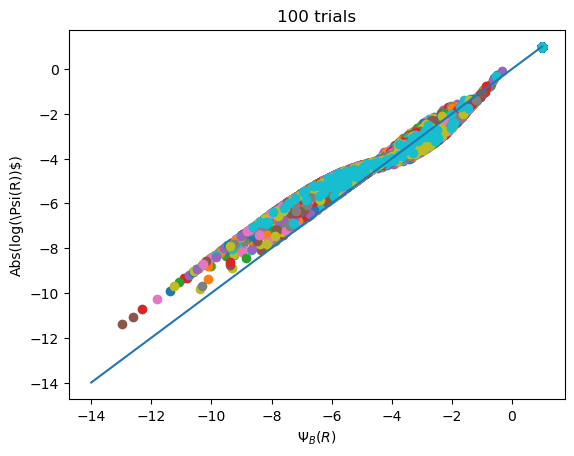

In [22]:
import importlib, bosonrecipes, mc, bosonwftools
modules = [bosonrecipes, mc, bosonwftools] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)

import importlib, wftools
modules = [wftools] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
    
#phi and phib
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig)
    wfb = initialize_boson_qmc_objects_j(
        scf_checkfile,
    )
    wf = initialize_qmc_objects_j(
            scf_checkfile,
        )
    e=0
    sign, phi1 = wf.recompute(configs)
    g1, _, _ = wf.gradient_value(e, configs.electron(e))  
    phi1 = wf.value()
    # phi1a = saved['phi']
    e=0
    signb, phi2 = wfb.recompute(configs)
    g1b, _, _ = wfb.gradient_value(e, configs.electron(e))
    phi2 = wfb.value()
    plt.scatter(phi1, phi2)
x = np.linspace(-14, 1, 100)
plt.plot(x,x)
plt.xlabel(r'$\Psi_B(R)$')
plt.ylabel(r'Abs(log(\Psi(R))$)')
plt.title(str(trials) + ' trials')

Text(0.5, 1.0, '100 configurations')

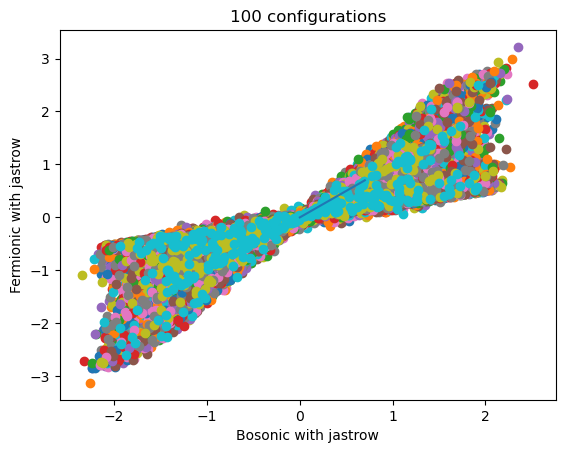

In [25]:
#Val and valb
trials = 100
for i in range(trials):
    nconfig = 100
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    configs = mc.initial_guess(mol, nconfig)
    wfb = initialize_boson_qmc_objects_j(
        scf_checkfile,
    )
    wf = initialize_qmc_objects_j(
            scf_checkfile,
        )
    e=0
    sign, val = wf.recompute(configs)
    g1, _, _ = wf.gradient_value(e, configs.electron(e))  
    e=0
    signb, valb = wfb.recompute(configs)
    g1b, _, _ = wfb.gradient_value(e, configs.electron(e))
    # valb2 = saved['psi']
    plt.scatter(g1, g1b)
x = np.linspace(0, 0.7, 100)
plt.plot(x,x)
plt.xlabel('Bosonic with jastrow')
plt.ylabel('Fermionic with jastrow')
plt.title(str(trials) + ' configurations')